In [ ]:
# import libraries:
# !pip install -Uq diffusers transformers fastcore

import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [ ]:
# initialize the model:
pipe = StableDiffusionPipeline.from_pretrained("pcuenq/jh_dreambooth_1000", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [3]:
# showing the image:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

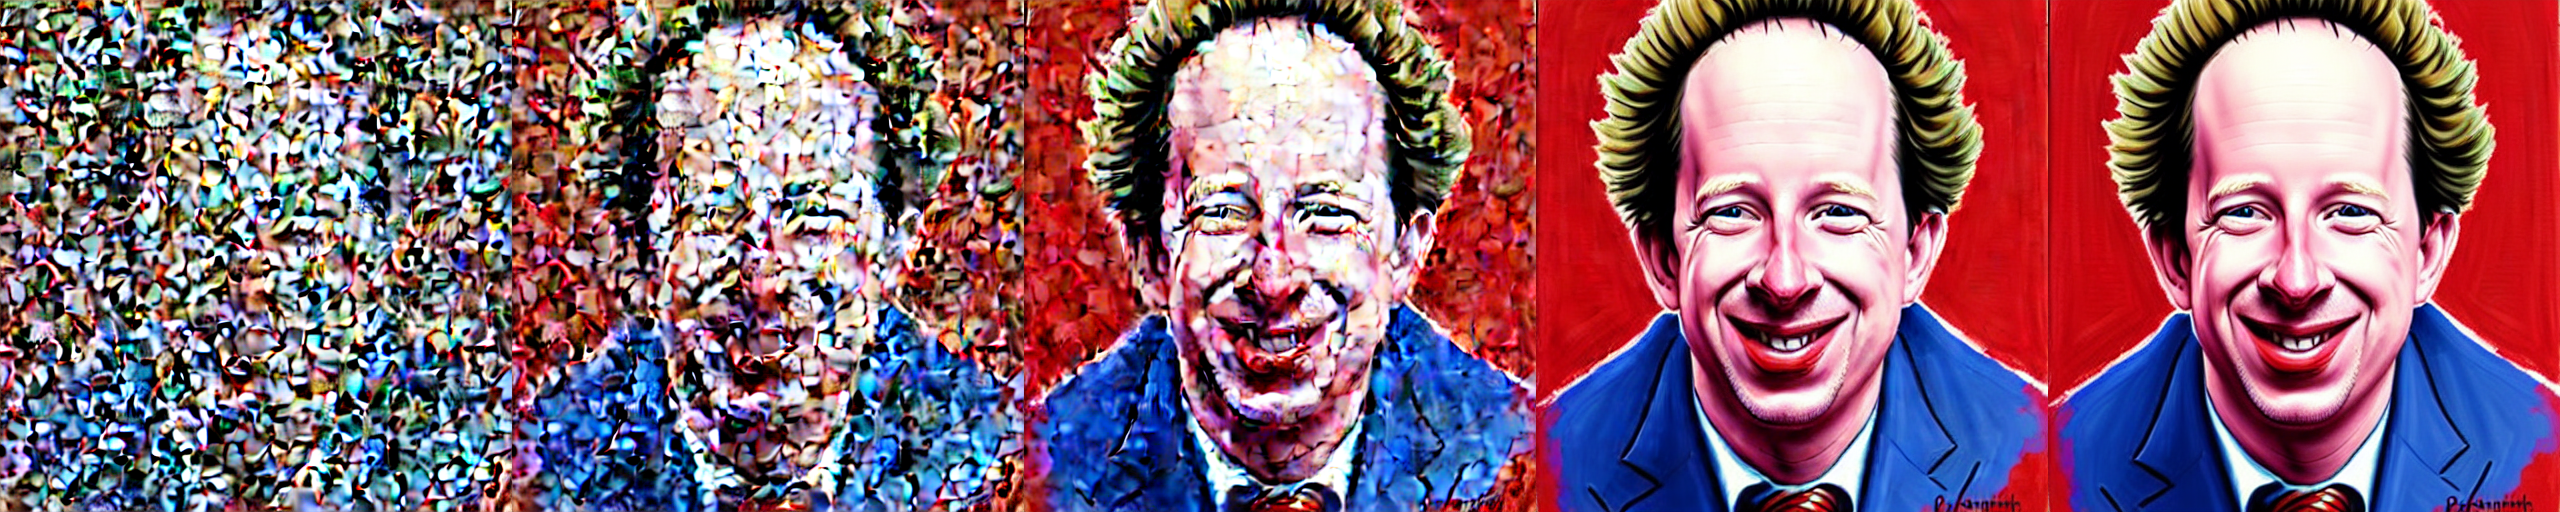

In [4]:
# denoising process:
vae = pipe.vae
images = []

def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(1, 2, 0).numpy()
    images.extend(pipe.numpy_to_pil(image))

prompt = "Portrait painting of Jeremy Howard looking happy."
torch.manual_seed(9000)
final_image = pipe(prompt, callback=latents_callback, callback_steps=12).images[0]
images.append(final_image)
image_grid(images, rows=1, cols=len(images))

In [5]:
# initialize the model:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

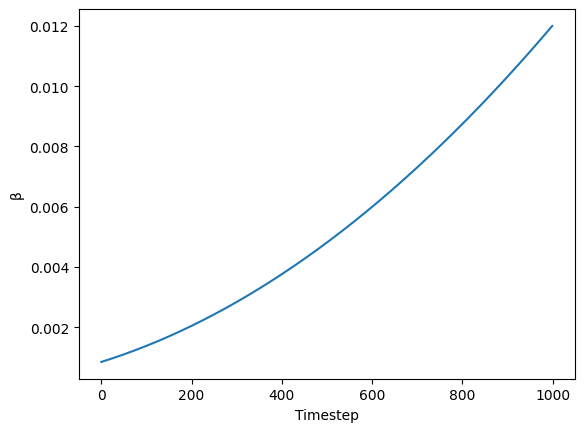

In [6]:
# inspecting the scheduler:
beta_start,beta_end = 0.00085,0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [7]:
# initializing scheduler:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [8]:
# initialize parameters:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [9]:
# tokenization:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [10]:
# initialize text embeddings:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

In [17]:
# unconditioned embeddings:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [16]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
# initializing:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()
latents.shape

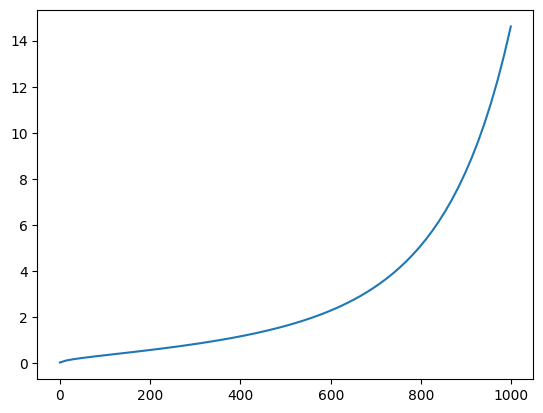

In [19]:
# scheduler:
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

In [20]:
from tqdm.auto import tqdm
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): 
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [21]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

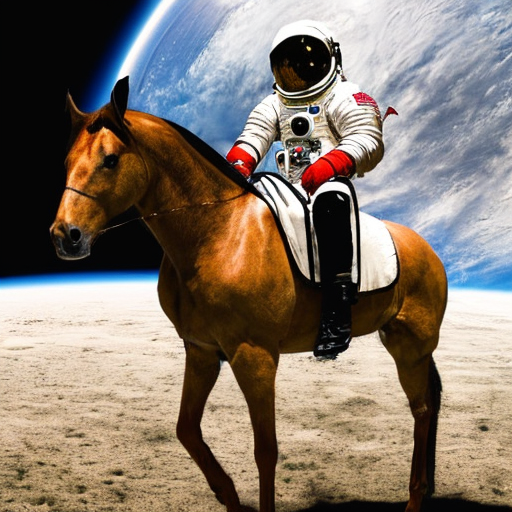

In [22]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)